In [ ]:
!pip install bertviz
!pip install transformers

In [2]:
import torch
from transformers import GPT2ForSequenceClassification, GPT2Config, GPT2Tokenizer, utils
from bertviz import model_view, head_view

/opt/miniconda3/envs/COMP551/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [66]:
model_name = "distilbert/distilgpt2"
n_labels = 28

model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name, num_labels=n_labels, output_attentions=True)

# get the GPT2 tokenizer
my_tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name)

# configure the tokenizer to add padding on the left side of sequences
# This is needed for sequence classification, as input sequences need to be of uniform length
my_tokenizer.padding_side = "left"

# set the pad_token of the tokenizer to be the same as the eos_token (GPT2 doesn't have a padding token by default)
my_tokenizer.pad_token = my_tokenizer.eos_token

# Initialize the GPT-2 model for sequence classification from the specified name and model configuration to set hyperparams such as n_labels
my_model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name, config=model_config)

# Adjust the model’s embedding layer to match the vocabulary size of the tokenizer
my_model.resize_token_embeddings(len(my_tokenizer))

my_model.config.pad_token_id = my_model.config.eos_token_id

file_name = '20241130_120655_gpt2_finetuned.pth'
my_model.load_state_dict(torch.load(file_name, map_location='cpu'))

/var/folders/pp/wwmz7vgd25z17bj0fvlc3g240000gn/T/ipykernel_71469/540343986.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  my_model.load_state_dict(torch.load(file_name

<All keys matched successfully>

In [73]:
def predict_class(phrase, model, tokenizer, device):
    # Ensure the model is in evaluation mode
    model.eval()

    # Tokenize the input phrase
    inputs = tokenizer(
        phrase,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512  # Ensure token sequence isn't too long
    ).to(device)

    # Get model output
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract logits and compute predicted class
    logits = outputs.logits  # Shape: [batch_size, n_labels]
    predicted_class = torch.argmax(logits, dim=1).item()  # Extract class label
    
    return predicted_class

Tokens sorted by attention with [CLS]:
ha: 0.915334939956665
this: 0.8912376761436462
##ha: 0.78019779920578
.: 0.7433823943138123
,: 0.49430331587791443
is: 0.4892596900463104
hilarious: 0.249254509806633


<IPython.core.display.Javascript object>

Predicted class: 1


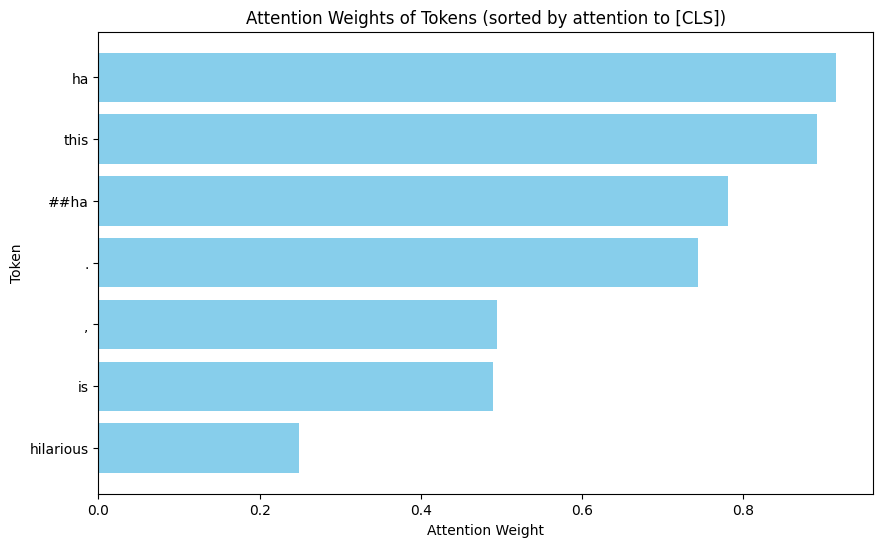

<IPython.core.display.Javascript object>

Predicted class: 1


In [92]:
from transformers import AutoTokenizer, AutoModel, utils
from bertviz import model_view
import matplotlib.pyplot as plt

utils.logging.set_verbosity_error()  # Suppress standard warnings
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
#tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name)
text = "Haha, this is hilarious."
#text = "This is just sad. So, so sad."

model = my_model # AutoModel.from_pretrained("distilbert-base-uncased", output_attentions=True)
inputs = tokenizer.encode(text, return_tensors='pt')
tokens = tokenizer.convert_ids_to_tokens(inputs[0]) 

with torch.no_grad():
    outputs = model(inputs)

attention = outputs[-1]  
layer = 5
head = 5
layer_attention = attention[layer][0]  
head_attention = layer_attention[head]

# Exclude `[CLS]` (index 0) and `[SEP]` (last index)
attention_scores = head_attention[1:-1]  # Remove CLS and SEP
tokens_without_special = tokens[1:-1]

# Pair tokens with their attention scores and sort in descending order
token_attention_pairs = list(zip(tokens_without_special, attention_scores))
#print(token_attention_pairs)
sorted_tokens = sorted(token_attention_pairs, key=lambda x: x[1][0], reverse=True)

# Print tokens in order of attention
print("Tokens sorted by attention with [CLS]:")
for token, score in sorted_tokens:
    print(f"{token}: {score[0]}")

head_view(attention, tokens)

predicted_class = predict_class(text, my_model, my_tokenizer, "cpu")
print("Predicted class:", predicted_class)
# Prepare data for plotting the histogram
attention_values = [score[0] for _, score in sorted_tokens]
tokens_for_plot = [token for token, _ in sorted_tokens]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.barh(tokens_for_plot, attention_values, color='skyblue')
plt.xlabel('Attention Weight')
plt.ylabel('Token')
plt.title('Attention Weights of Tokens (sorted by attention to [CLS])')
plt.gca().invert_yaxis()  # To display the highest attention at the top
plt.show()

# View the attention head with bertviz
head_view(attention, tokens)

# Predict the class (if needed)
predicted_class = predict_class(text, my_model, my_tokenizer, "cpu")
print("Predicted class:", predicted_class)

In [ ]:
import matplotlib.pyplot as plt

# Data for the two tables
data1 = [
    ("good", 0.9217),
    ("all", 0.8559),
    ("ha", 0.6208),
    ("##ha", 0.4609),
    ("man", 0.3338),
]

data2 = [
    ("this", 0.9471),
    (".", 0.6954),
    ("is", 0.5668),
    ("just", 0.4612),
    ("so", 0.3224),
    (",", 0.2041),
    ("so", 0.1970),
    ("sad", 0.1787),
    ("sad", 0.0925),
    (".", 0.0095),
]

# Creating the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First table data
tokens1, attention1 = zip(*data1)
axes[0].barh(tokens1, attention1, color="skyblue")
axes[0].set_xlabel("Attention Weight")
axes[0].set_title("Tokens")
axes[0].invert_yaxis()

# Second table data
tokens2, attention2 = zip(*data2)
axes[1].barh(tokens2, attention2, color="lightgreen")
axes[1].set_xlabel("Attention Weight")
axes[1].set_title("Tokens (Figure 2)")
axes[1].invert_yaxis()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()